# Calculations with Uflyand-Mindlin shells

In [1]:
from sigmaepsilon.solid.material import MindlinShellSection as Section
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

E = 2890.0
nu = 0.2
yield_strength = 2.0
thickness = 25.0

hooke = elastic_stiffness_matrix(E=E, NU=nu)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)

failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)

material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

section = Section(
    layers=[
        Section.Layer(material=material, thickness=thickness / 3),
        Section.Layer(material=material, thickness=thickness / 3),
        Section.Layer(material=material, thickness=thickness / 3),
    ]
)
section.elastic_stiffness_matrix().shape

f:\GitHub\SigmaEpsilon\sigmaepsilon.solid.material\.solid.material\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


(8, 8)

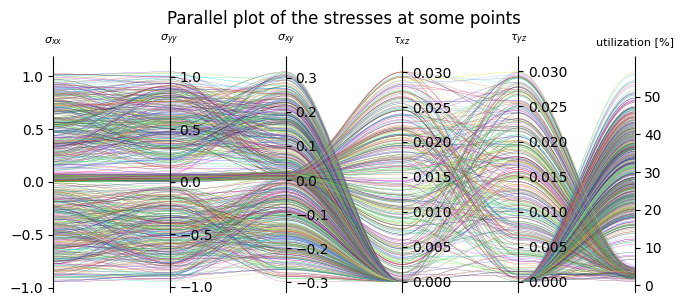

In [2]:
from sigmaepsilon.mesh.plotting import parallel_mpl
import numpy as np

strains = 2 * np.random.rand(300, 8) / 100000  # random data
z = np.array([-1.0, 0.0, 1.0])

stresses = section.calculate_stresses(strains=strains, z=z).values
util = section.utilization(strains=strains, z=z).values * 100

nXY, nZ, nStress = stresses.shape
stresses = stresses.reshape((nXY*nZ, nStress))
util = util.reshape((nXY*nZ))

colors = np.random.rand(stresses.shape[0], 3)
labels = [str(i) for i in range(stresses.shape[-1])]
values = [stresses[:, i] for i in range(stresses.shape[-1])]
values += [util,]

labels = [r"$\sigma_{xx}$", r"$\sigma_{yy}$", r"$\sigma_{xy}$", r"$\tau_{xz}$", r"$\tau_{yz}$"]
labels += [r"utilization [%]"]

_ = parallel_mpl(
    values,
    labels=labels,
    padding=0.05,
    lw=0.2,
    colors=colors,
    title="Parallel plot of the stresses at some points",
)